# Week 4 - Data retrieval and dataset preprocessing
# Exercise Solutions

In [1]:
# required packages:
import numpy as np
import pandas as pd
import sklearn
import skimage
import sqlalchemy as sa

import urllib.request
import requests
import sys
import json
import pickle
import gzip
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymysql
import pymysql

### Part 1
1. Plot the distribution of expression levels for EGFR (filter by gene_name) in breast cancer samples from protein_expression.BRCA-US.tsv.gz
2. Count the number of common SNPs on Chromosome M  (based on snp147Common table)

In [2]:
ICGC_API = 'https://dcc.icgc.org/api/v1/download?fn=/release_18/Projects/BRCA-US/'
expression_fname = 'protein_expression.BRCA-US.tsv.gz'

if not Path(expression_fname).is_file():
    print("Downloading file", ICGC_API + expression_fname, "saving it as", expression_fname)
    urllib.request.urlretrieve(ICGC_API + expression_fname, expression_fname);
else:
    print("Local file exists:", expression_fname)

Local file exists: protein_expression.BRCA-US.tsv.gz


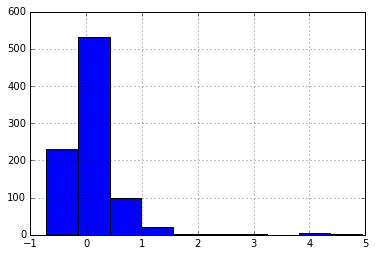

In [3]:
E = pd.read_csv(expression_fname, delimiter='\t')
E[E['gene_name'] == 'EGFR']['normalized_expression_level'].hist()

In [4]:
engine = sa.create_engine('mysql+pymysql://genome@genome-mysql.cse.ucsc.edu/hg38', poolclass=sa.pool.NullPool)

meta = sa.MetaData(bind=engine)
meta.reflect(only=['snp147Common'])

snp_table = sa.Table('snp147Common',
    meta,
    sa.PrimaryKeyConstraint('name'),
    extend_existing=True)

# Solution option #1
expr = sa.select([snp_table]).where(snp_table.c.chrom == 'chrM')
df = pd.read_sql(expr, engine)
print("Number of SNPs", df.name.nunique())
    
# Solution option #2
r = engine.scalar(sa.select([snp_table]).where(snp_table.c.chrom == 'chrM').alias('snp').count())
print("Number of SNPs", r)


Number of SNPs 145
Number of SNPs 145


### Part 2

1. Substitute missing values in `x` with the column mean and add an additional column to indicate when missing values have been substituted. The `isnull` method on the pandas dataframe may be useful.
2. Convert `x` to the z-scaled values. The StandardScaler method in the preprocessing module can be used or the z-scaled values calculated directly.
3. Convert `x['C']` into a categorical variable using a threshold of 0.125 

In [20]:
x = pd.DataFrame([[0,1,2,3,4,5,6],
                  [2,np.nan,7,4,9,1,3],
                  [0.1,0.12,0.11,0.15,0.16,0.11,0.14],
                  [100,120,np.nan,127,130,121,124],
                  [4,1,7,9,0,2,np.nan]], ).T
x.columns = index=['A', 'B', 'C', 'D', 'E']
print(x)

# 1
x_filled = x.copy()
x_filled['any_missing'] = x.isnull().any(axis=1)
x_filled = x_filled.fillna(value=x_filled.mean())
print(x_filled)

# 2
# It is not possible to transform data with missing values x, therefore we use fillna()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = x.fillna(value=x.mean())
x_scaled[['A', 'B', 'C', 'D', 'E']] = scaler.fit_transform(x_scaled[['A', 'B', 'C', 'D', 'E']])
print(x_scaled)

# 3
x_cat = x.copy()
x_cat['C_cat'] = x['C'] > 0.125
print(x_cat)

     A    B     C      D    E
0  0.0  2.0  0.10  100.0  4.0
1  1.0  NaN  0.12  120.0  1.0
2  2.0  7.0  0.11    NaN  7.0
3  3.0  4.0  0.15  127.0  9.0
4  4.0  9.0  0.16  130.0  0.0
5  5.0  1.0  0.11  121.0  2.0
6  6.0  3.0  0.14  124.0  NaN
     A         B     C           D         E any_missing
0  0.0  2.000000  0.10  100.000000  4.000000       False
1  1.0  4.333333  0.12  120.000000  1.000000        True
2  2.0  7.000000  0.11  120.333333  7.000000        True
3  3.0  4.000000  0.15  127.000000  9.000000       False
4  4.0  9.000000  0.16  130.000000  0.000000       False
5  5.0  1.000000  0.11  121.000000  2.000000       False
6  6.0  3.000000  0.14  124.000000  3.833333        True
     A         B        C         D             E
0 -1.5 -0.897309 -1.28098 -2.262587  5.562919e-02
1 -1.0  0.000000 -0.33710 -0.037092 -9.456962e-01
2 -0.5  1.025497 -0.80904  0.000000  1.056955e+00
3  0.0 -0.128187  1.07872  0.741832  1.724505e+00
4  0.5  1.794619  1.55066  1.075656 -1.279471e+00
5  1

### Part 3
1. Choose one of the histogram processing methods and apply it to the page example.
2. Take patches for the page example used above at different scales (10, 20 and 40 pixels). The resulting patches should be [rescaled](http://scikit-image.org/docs/stable/api/skimage.transform.html#rescale) to have the same size.
3. Change the vectorization approach to ignore very common words such as 'the' and 'a'. These are known as stop words. Reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) should help.
4. Change the vectorization approach to consider both single words and sequences of 2 words. Reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) should help.

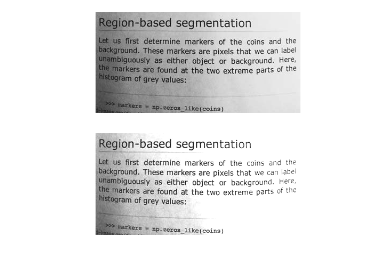

In [6]:
# 1

import skimage.data

img = skimage.data.page()

# Contrast stretching
p2, p98 = np.percentile(img, (0, 50))
img_rescale = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].imshow(img, cmap=plt.cm.gray)
axs[0].set_axis_off()
axs[1].imshow(img_rescale, cmap=plt.cm.gray)
axs[1].set_axis_off()
plt.show()

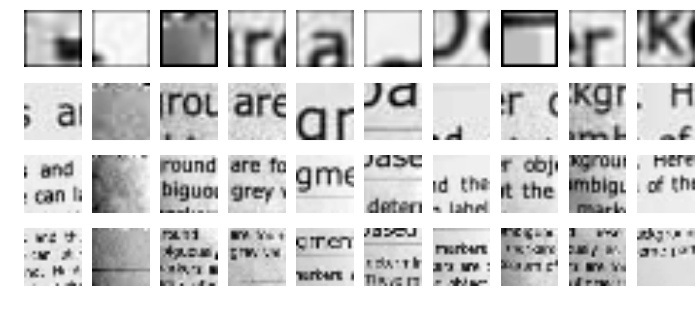

In [7]:
# 2

import sklearn.feature_extraction
import skimage.transform

page_img = skimage.data.page()

fig, axs = plt.subplots(4, 10, sharex=True, sharey=True, figsize=(12, 5))
# extract patches of different sizes
for i, patch_size in enumerate((10, 20, 40, 60)):
    patches = sklearn.feature_extraction.image.extract_patches_2d(page_img, (patch_size, patch_size), max_patches=10, random_state=0)
    for j, patch in enumerate(patches):
        # scale patches (up or down) to 20x20px regardless of patch size
        scaling_factor = 20.0 / patch_size
        rescaled_patch = skimage.transform.rescale(patch, scale=scaling_factor)
        axs[i, j].imshow(rescaled_patch, cmap=plt.cm.gray)
        axs[i, j].set_axis_off()
plt.show()

In [9]:
import sklearn.feature_extraction
import sklearn.datasets

twenty_train = sklearn.datasets.fetch_20newsgroups(subset='train',
    categories=['comp.graphics', 'sci.med'], shuffle=True, random_state=0)

count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
print("\nNo stop words:")
print("\tN documents", X_train_counts.shape[0])
print("\tM features", X_train_counts.shape[1])

# 3
count_vect = sklearn.feature_extraction.text.CountVectorizer(stop_words=('the', 'a', 'software'))
X_train_counts = count_vect.fit_transform(twenty_train.data)
print("\nWith stop words")
print("\tN documents", X_train_counts.shape[0])
print("\tM features", X_train_counts.shape[1])

# 4
count_vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(twenty_train.data)
print("\nSingle words and sequences of two words")
print("\tN documents", X_train_counts.shape[0])
print("\tM features", X_train_counts.shape[1])
print("\tLast 10 features", count_vect.get_feature_names()[-10:])


No stop words:
	N documents 1178
	M features 24614

With stop words
	N documents 1178
	M features 24612

Single words and sequences of two words
	N documents 1178
	M features 167838
	Last 10 features ['zyeh caspian', 'zyxel', 'zyxel 14', 'zyxel v32bis', 'zz', 'zzz', 'ªl', 'ªl r0506048', 'íålittin', 'íålittin no']
